In [63]:
# a. import
import ipywidgets as widgets
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from HouseholdSpecializationModel import *
import math
from types import SimpleNamespace

## Question 1

In [64]:
# Define the values of alpha and sigma to use

alpha_values = [0.25, 0.5, 0.75]
sigma_values = [0.5, 1, 1.5]
mo = HouseholdSpecializationModelClass()
for alpha in alpha_values:
    for sigma in sigma_values:
        mo.par.alpha = alpha
        mo.par.sigma = sigma
        res = mo.solve_discrete()
        print(f'({alpha},{sigma}): x = {res.HF/res.HM:.3f}')
        


/Users/andersbruun/projects-2023-siuuu/inauguralproject/HouseholdSpecializationModel.py:62: RuntimeWarning: divide by zero encountered in reciprocal
  else:
/Users/andersbruun/projects-2023-siuuu/inauguralproject/HouseholdSpecializationModel.py:62: RuntimeWarning: invalid value encountered in reciprocal
  else:
/Users/andersbruun/projects-2023-siuuu/inauguralproject/HouseholdSpecializationModel.py:66: RuntimeWarning: invalid value encountered in reciprocal
  Q = C**par.omega*H**(1-par.omega)


(0.25,0.5): x = 0.600
(0.25,1): x = 0.333
(0.25,1.5): x = 0.200
(0.5,0.5): x = 1.000
(0.5,1): x = 1.000
(0.5,1.5): x = 1.000
(0.75,0.5): x = 1.667
(0.75,1): x = 3.000
(0.75,1.5): x = 5.000


## Question 2:


[0.20479441264601322, 0.083381608939051, 0.0, -0.08338160893905101, -0.1670540846631662]


Text(0, 0.5, 'Log(wF)')

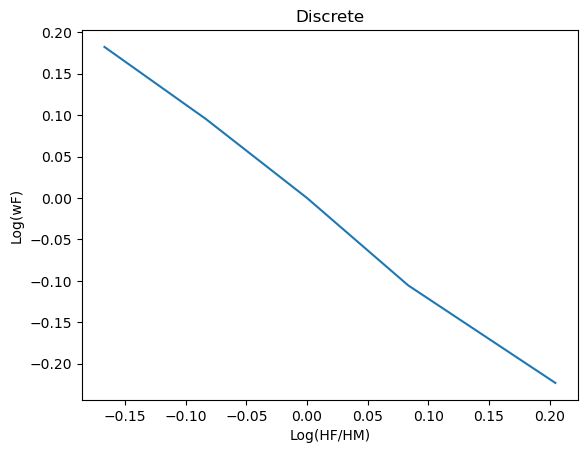

In [65]:
#Returner H forhold for loop over alpha og sigma værdier
wF_values = [0.8, 0.9, 1.0, 1.1, 1.2]
wM = 1.0
Log_ratio = []
import math
for wF in wF_values:
    model = HouseholdSpecializationModelClass()
    model.par.wF = wF
    model.par.wM = wM
    opt = model.solve_discrete()
    Log_ratio.append(math.log(opt.HF/opt.HM))
print(Log_ratio)

plt.plot(Log_ratio, np.log(wF_values))
plt.title('Discrete')
plt.xlabel('Log(HF/HM)')
plt.ylabel('Log(wF)')



## Question 3

[0.4249619071162582, 0.4499816454048216, 0.47010576017732264, 0.49258730239387793, 0.5127456832488608]


Text(0, 0.5, 'Log(wF)')

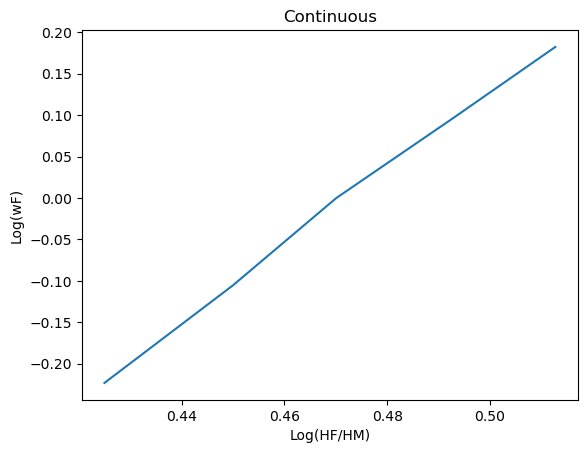

In [66]:
# Forhold mellem WF og WM
import numpy as np
wF_values = [0.8, 0.9, 1.0, 1.1, 1.2]
wM = 1.0
Log_ratio = []
import math
for wF in wF_values:
    model = HouseholdSpecializationModelClass()
    model.par.wF = wF
    model.par.wM = wM
    opt = model.solve_cont()
    Log_ratio.append(math.log(opt['HF']/opt['HM']))
print(Log_ratio)

plt.plot(Log_ratio, np.log(wF_values))
plt.title('Continuous')
plt.xlabel('Log(HF/HM)')
plt.ylabel('Log(wF)')


## Question 4: